In [2]:
import sys
from cifar_very_tiny import *
from cifar_tiny import * 
from cifar_dataset import *   
from resnet import * 
from mut_info import *
import torch
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pylab as plt
import matplotlib.cm as cm
import json
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import optuna


%matplotlib inline
plt.rcParams['figure.figsize']=(12,9)
plt.rcParams['font.size']= 20

In [3]:
train_loader, test_loader = cifar10_loader(batch_size=128, maxsize=10112)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
kl = nn.KLDivLoss(reduction="batchmean")
sm = nn.Softmax(dim=1)

def distill(out, teacher_out, temp):
    g = sm(out / temp)
    f = F.log_softmax(teacher_out / temp)
    return kl(f, g)

In [5]:
def accuracy_plot(data):
    plt.rcParams['font.family'] = 'DejaVu Serif'
    plt.rcParams['lines.linewidth'] = 2
    plt.rcParams['lines.markersize'] = 12
    plt.rcParams['xtick.labelsize'] = 24
    plt.rcParams['ytick.labelsize'] = 24
    plt.rcParams['legend.fontsize'] = 24
    plt.rcParams['axes.titlesize'] = 36
    plt.rcParams['axes.labelsize'] = 24

    fig, ax = plt.subplots()

    for d in data:
        ax.plot(d)

    ax.grid()

    ax.set_xlabel('epoch')
    ax.set_ylabel('accuracy')

    plt.show()

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
epoch_num = 30

In [7]:
def accuracy(model):
    total = 0
    correct = 0
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            correct += torch.eq(torch.argmax(out, 1), y).sum()
            total += len(x)
    return (correct / total).cpu().detach().numpy()

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

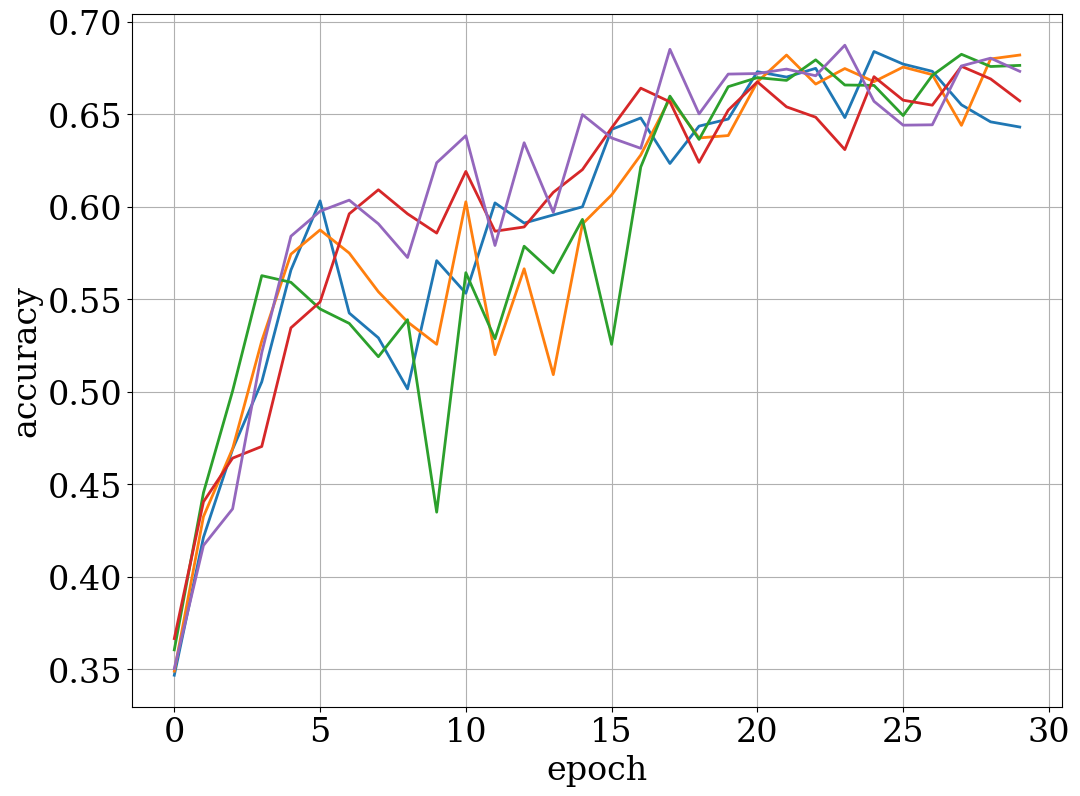

In [8]:
resnet10_accuracy = []
for _ in range(5):
    teacher = ResNet10(10).to(device)
    optim = torch.optim.Adam(teacher.parameters())
    crit = nn.CrossEntropyLoss()
    tq = tqdm(range(epoch_num))
    resnet10_accuracy.append([])
    for epoch in tq:
        losses = []
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            teacher.zero_grad()
            out = teacher(x)
            loss = crit(teacher(x), y)
            losses.append(loss.cpu().detach().numpy())
            loss.backward()
            optim.step()
        tq.set_description("loss: {:.4f}".format(np.mean(losses[-10:])))
        teacher.eval()
        resnet10_accuracy[-1].append(accuracy(teacher))
        teacher.train()
accuracy_plot(resnet10_accuracy)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

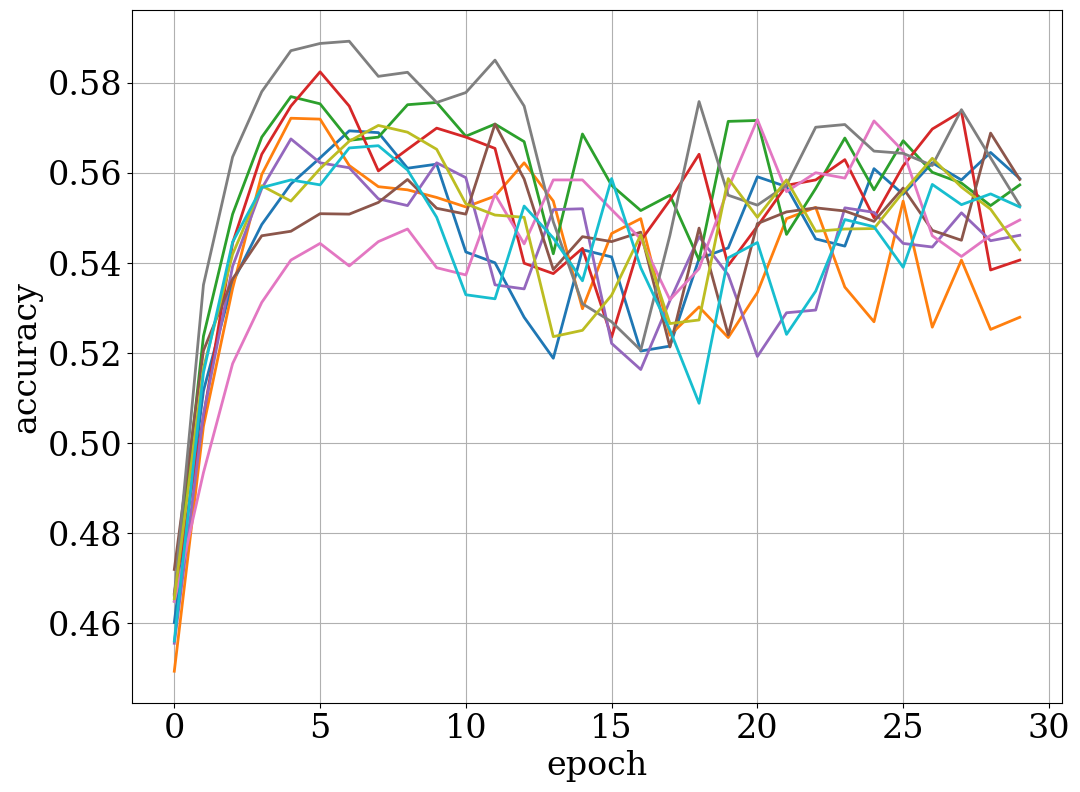

In [9]:
cifar_tiny_accuracy = []
for _ in range(10):
    student = Cifar_Tiny(10).to(device)
    optim = torch.optim.Adam(student.parameters())
    crit = nn.CrossEntropyLoss()
    tq = tqdm(range(epoch_num))
    cifar_tiny_accuracy.append([])
    for epoch in tq:
        losses = []
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            student.zero_grad()
            out = student(x)
            loss = crit(student(x), y)
            losses.append(loss.cpu().detach().numpy())
            loss.backward()
            optim.step()
        tq.set_description("loss: {:.4f}".format(np.mean(losses[-10:])))
        student.eval()
        cifar_tiny_accuracy[-1].append(accuracy(student))
        student.train()
accuracy_plot(cifar_tiny_accuracy)

hyperparameters 0.00311763447155311 0.1015422336046973


  0%|          | 0/30 [00:00<?, ?it/s]

/tmp/ipykernel_12079/2137037151.py:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = F.log_softmax(teacher_out / temp)


hyperparameters 0.7313564346098744 0.2906953278838006


  0%|          | 0/30 [00:00<?, ?it/s]

hyperparameters 0.5524517191448759 0.46061763259751815


  0%|          | 0/30 [00:00<?, ?it/s]

hyperparameters 0.7007038546632943 3.5712028693299054


  0%|          | 0/30 [00:00<?, ?it/s]

hyperparameters 0.7761368371185798 1.2430405006903618


  0%|          | 0/30 [00:00<?, ?it/s]

hyperparameters 0.5184525880836045 2.9719564503353726


  0%|          | 0/30 [00:00<?, ?it/s]

hyperparameters 0.6584069198971738 0.3622545437284613


  0%|          | 0/30 [00:00<?, ?it/s]

hyperparameters 0.8504904802769884 6.055739020462313


  0%|          | 0/30 [00:00<?, ?it/s]

hyperparameters 0.0992317455827616 0.2939845223707058


  0%|          | 0/30 [00:00<?, ?it/s]

hyperparameters 0.3981181078479088 3.449461066120411


  0%|          | 0/30 [00:00<?, ?it/s]

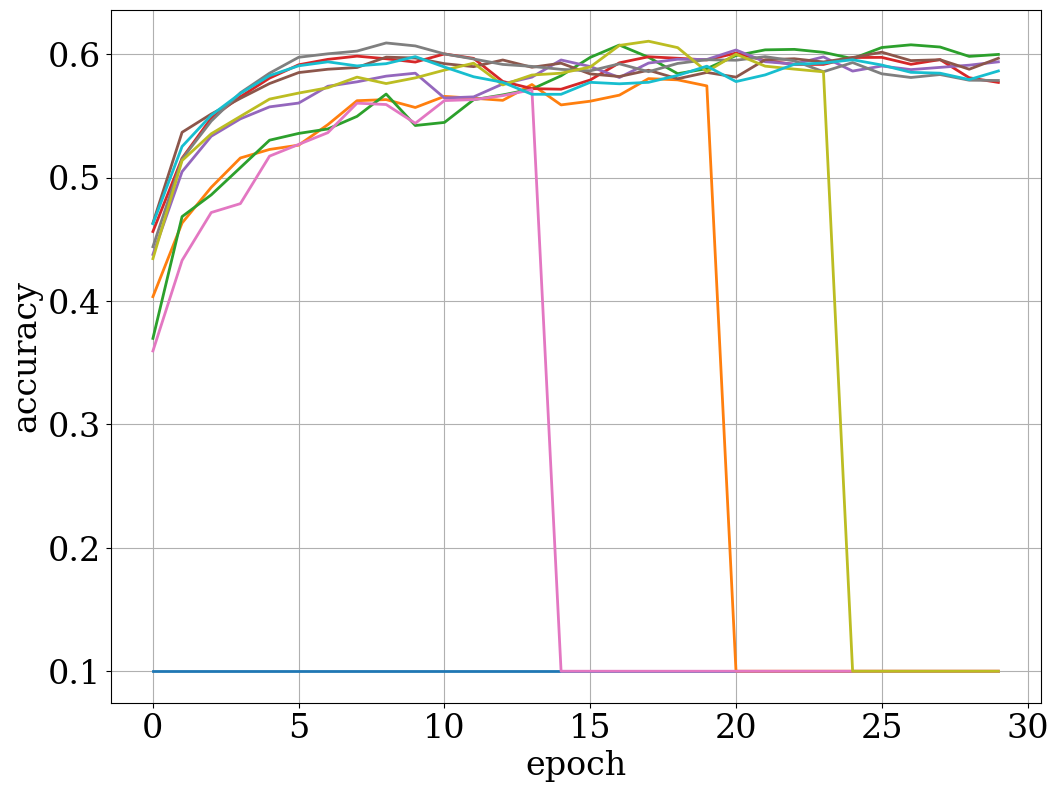

In [10]:
cifar_tiny_hinton_results = []
for _ in range(10):
    beta = np.random.uniform()
    temp = 10 ** (np.random.uniform(low=-1, high=1))  # температура от 0.1 до 10
    print("hyperparameters", beta, temp)
    student = Cifar_Tiny(10).to(device)
    optim = torch.optim.Adam(student.parameters())
    crit = nn.CrossEntropyLoss()
    tq = tqdm(range(epoch_num))
    cifar_tiny_hinton_results.append([])
    for _ in tq:
        losses = []
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            student.zero_grad()
            out = student(x)
            with torch.no_grad():
                teacher_out = teacher(x)
            student_loss = crit(student(x), y)
            distillation_loss = distill(out, teacher_out, temp)
            loss = (1 - beta) * student_loss + beta * distillation_loss
            losses.append(loss.cpu().detach().numpy())
            loss.backward()
            optim.step()
        tq.set_description("current loss:{}".format(np.mean(losses[-10:])))
        cifar_tiny_hinton_results[-1].append(accuracy(student))
accuracy_plot(cifar_tiny_hinton_results)

In [18]:
student_sizes = list(map(lambda f: f.shape, student.get_features(x, [0, 1, 2, 3, 4])))
teacher_sizes = list(map(lambda f: f.shape, teacher.get_features(x)))

In [22]:
def objective(trial):
    crit = nn.CrossEntropyLoss()
    student = Cifar_Tiny(10).to(device)
    
    beta = trial.suggest_float("beta", 0.1, 0.9, log=True)
    n = 4 * 9
    x = []
    for i in range(n):
        x.append(- np.log(trial.suggest_float(f"x_{i}", 0, 1, log=False)))

    coeffs = []
    for i in range(n):
        coeffs.append(x[i] / sum(x[(i//9)*9:((i//9)+1)*9]))

    #    (student layer, teacher layer, lambda, model, sigma)
    connections = [(i, j, coeffs[i * 4 + j], 
                    get_mu_transform(student_sizes[i], teacher_sizes[j]).to(device), 
                    torch.nn.Parameter(torch.zeros(1).to(device)))
                   for j in range(9)
                   for i in range(4)]

    for i in range(len(connections)):
        trial.set_user_attr(f"l_{connections[i][0]}_{connections[i][1]}", connections[i][2])
    
    learnable_params = list(student.parameters())
    for _, _, _, model, sigma in connections:
        learnable_params += list(model.parameters())
        learnable_params += [sigma]
    optim = torch.optim.Adam(learnable_params)

    tq = tqdm(range(epoch_num))
    for epoch in tq:
        losses = []

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            optim.zero_grad()
            
            
            *student_feat, student_logits = student.get_features(x, [0, 1, 2, 3, 4])
            teacher_feat = teacher.get_features(x)
            
            feat_loss_sum = 0
            for student_idx, teacher_idx, lmbda, mi_model, log_sigma  in connections:
                my_stud_feat = mi_model(student_feat[student_idx])
                my_stud_feat = my_stud_feat.view(my_stud_feat.size(0), -1)
                my_teacher_feat = teacher_feat[teacher_idx].view(teacher_feat[teacher_idx].size(0), -1)
                
                sigma2 = torch.log(1 + torch.exp(log_sigma))
                feat_loss = ((my_teacher_feat - my_stud_feat) ** 2).sum(
                    1
                ).mean() / 2 * sigma2 + 0.5*torch.log(sigma2)
                feat_loss_sum += lmbda * feat_loss
                
            class_loss = crit(student_logits, y)
            loss = class_loss * (1.0-beta) + feat_loss * beta / 4

            loss.backward()
            optim.step()
            losses.append(loss.detach().cpu().numpy())
        tq.set_description("loss: {:.4f}".format(np.mean(losses[-10:]))) 
        #scheduler.step()
        student.eval()
        ac = accuracy(student)
        student.train()
        with open('../logs/acc_upd_mi_all_resnet_10_tiny.txt','a') as out:
            out.write('{}: {}\n'.format(epoch, ac))
    return ac

In [23]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2023-04-10 21:32:20,949] A new study created in memory with name: no-name-0293847d-2020-4396-881b-39c8749ba0d9


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-10 21:36:13,615] Trial 0 finished with value: 0.5907999873161316 and parameters: {'beta': 0.23793199649051075, 'x_0': 0.4414861441081731, 'x_1': 0.5600432179646162, 'x_2': 0.7423346963897585, 'x_3': 0.251585960415605, 'x_4': 0.8916520605800822, 'x_5': 0.33439819662821, 'x_6': 0.29359343453251596, 'x_7': 0.20861491208845362, 'x_8': 0.8268523398802743, 'x_9': 0.5989884642391533, 'x_10': 0.912371098246306, 'x_11': 0.2518861731395051, 'x_12': 0.8830960973893303, 'x_13': 0.7187176786550478, 'x_14': 0.4951862832957772, 'x_15': 0.47466075589996104, 'x_16': 0.43461191739781935, 'x_17': 0.5293364848498749, 'x_18': 0.16286351086143724, 'x_19': 0.5147354735410412, 'x_20': 0.9221855530477763, 'x_21': 0.6634730414032275, 'x_22': 0.1677834582074551, 'x_23': 0.45146043154471893, 'x_24': 0.35280156934147255, 'x_25': 0.698571845558586, 'x_26': 0.7974218586340907, 'x_27': 0.31324101681794947, 'x_28': 0.24759828002203188, 'x_29': 0.07187421132512573, 'x_30': 0.3047660269634038, 'x_31': 0.46741

  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-10 21:40:05,453] Trial 1 finished with value: 0.6229999661445618 and parameters: {'beta': 0.16148749370962315, 'x_0': 0.8634079962600125, 'x_1': 0.11511576197845341, 'x_2': 0.5462882357164724, 'x_3': 0.9976110731792404, 'x_4': 0.7506912372651029, 'x_5': 0.3680685675460432, 'x_6': 0.6881541756329711, 'x_7': 0.9897902413827694, 'x_8': 0.732801230936981, 'x_9': 0.09584651562520274, 'x_10': 0.22657708227580498, 'x_11': 0.9461977955379818, 'x_12': 0.18112983435106844, 'x_13': 0.6215067012963267, 'x_14': 0.5022620268933996, 'x_15': 0.5805135537631508, 'x_16': 0.23006677299528455, 'x_17': 0.3958597302956264, 'x_18': 0.39963629356657027, 'x_19': 0.9501257165529794, 'x_20': 0.963944001147244, 'x_21': 0.40581898474959743, 'x_22': 0.20240979099259537, 'x_23': 0.22008445034959068, 'x_24': 0.1880130205735714, 'x_25': 0.0019249098471245674, 'x_26': 0.01663820510393932, 'x_27': 0.5510464781002943, 'x_28': 0.39213508850388834, 'x_29': 0.14490010846730728, 'x_30': 0.3257295125534976, 'x_31':

  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-10 21:43:56,858] Trial 2 finished with value: 0.5913999676704407 and parameters: {'beta': 0.17245370582496172, 'x_0': 0.8555747008757025, 'x_1': 0.8968096341575595, 'x_2': 0.7622129570989494, 'x_3': 0.7432130365877683, 'x_4': 0.7607521446176608, 'x_5': 0.5653994678773753, 'x_6': 0.7815074312104773, 'x_7': 0.9316885765382092, 'x_8': 0.41741855813909245, 'x_9': 0.8877837749127295, 'x_10': 0.007149721069330761, 'x_11': 0.04895721435378508, 'x_12': 0.9012776024729661, 'x_13': 0.15954083088232318, 'x_14': 0.846803138799521, 'x_15': 0.22463637264809722, 'x_16': 0.263944341221622, 'x_17': 0.1499469027789817, 'x_18': 0.6793670524620182, 'x_19': 0.4200134698077165, 'x_20': 0.8441990711357303, 'x_21': 0.6610132605212755, 'x_22': 0.016356923326009243, 'x_23': 0.5331954700934729, 'x_24': 0.7296667220366211, 'x_25': 0.8758087570907238, 'x_26': 0.5610814034530655, 'x_27': 0.9242409785053447, 'x_28': 0.6625657053598061, 'x_29': 0.6060175843840067, 'x_30': 0.32907432959123784, 'x_31': 0.658

  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-10 21:47:49,770] Trial 3 finished with value: 0.6128999590873718 and parameters: {'beta': 0.13913715832806767, 'x_0': 0.4233399382674753, 'x_1': 0.7851126320240064, 'x_2': 0.7883530096371817, 'x_3': 0.47408935686660936, 'x_4': 0.41311645898223126, 'x_5': 0.1405929144046275, 'x_6': 0.40840198854384346, 'x_7': 0.6088185718789025, 'x_8': 0.7468933494942568, 'x_9': 0.7268921444386696, 'x_10': 0.9520469872207351, 'x_11': 0.2961502194557297, 'x_12': 0.7422984544051832, 'x_13': 0.3961260782497551, 'x_14': 0.7904398859918328, 'x_15': 0.823573984983427, 'x_16': 0.8556703201313776, 'x_17': 0.6322034387127615, 'x_18': 0.44924193461138484, 'x_19': 0.6015932488094099, 'x_20': 0.4804883203253346, 'x_21': 0.21341459528993367, 'x_22': 0.2192485790537022, 'x_23': 0.9508433049517528, 'x_24': 0.4459439190728539, 'x_25': 0.0807222336616834, 'x_26': 0.7730403116803296, 'x_27': 0.66087476714024, 'x_28': 0.9968250220965087, 'x_29': 0.4139112966449694, 'x_30': 0.8998026855528304, 'x_31': 0.39541166

  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-10 21:51:43,741] Trial 4 finished with value: 0.6067999601364136 and parameters: {'beta': 0.1778218176596261, 'x_0': 0.3358436720463859, 'x_1': 0.16398272510323375, 'x_2': 0.41713306285259, 'x_3': 0.6381629627732137, 'x_4': 0.18173877757406798, 'x_5': 0.3563170754133679, 'x_6': 0.48660314411411654, 'x_7': 0.16567440402202904, 'x_8': 0.6373374022565831, 'x_9': 0.948281350539514, 'x_10': 0.6014597539254988, 'x_11': 0.6665270422408373, 'x_12': 0.015666574260823074, 'x_13': 0.807619886564763, 'x_14': 0.04614574928685389, 'x_15': 0.02502624050822122, 'x_16': 0.2705917444519421, 'x_17': 0.9797304187713887, 'x_18': 0.8353042209249518, 'x_19': 0.03321523959079398, 'x_20': 0.8702554693211615, 'x_21': 0.6553045772134637, 'x_22': 0.7022168830454846, 'x_23': 0.2808020536122219, 'x_24': 0.6371237977811804, 'x_25': 0.31767955921309, 'x_26': 0.5750044510190253, 'x_27': 0.23527708696143523, 'x_28': 0.47148479802350374, 'x_29': 0.13790517551863546, 'x_30': 0.023463701564244932, 'x_31': 0.912

  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-10 21:55:38,422] Trial 5 finished with value: 0.6259999871253967 and parameters: {'beta': 0.17066595981057858, 'x_0': 0.5569157779474417, 'x_1': 0.7663682443100973, 'x_2': 0.29436835647595616, 'x_3': 0.8627374058498771, 'x_4': 0.03964347942768787, 'x_5': 0.07847389716028308, 'x_6': 0.05613623616955832, 'x_7': 0.14166745753170695, 'x_8': 0.22464950668588912, 'x_9': 0.9195385280342038, 'x_10': 0.716299184550122, 'x_11': 0.4760038517507249, 'x_12': 0.601837710009906, 'x_13': 0.5828705115899853, 'x_14': 0.7549023026329504, 'x_15': 0.4747250661810667, 'x_16': 0.11416743463672774, 'x_17': 0.7806920949050792, 'x_18': 0.34792987999972247, 'x_19': 0.47955082536934657, 'x_20': 0.39149071788530965, 'x_21': 0.34377937370720746, 'x_22': 0.023095412585936503, 'x_23': 0.52113011682783, 'x_24': 0.26321438973993827, 'x_25': 0.6096989637148278, 'x_26': 0.6376557038075575, 'x_27': 0.7530268681784063, 'x_28': 0.6461962442012531, 'x_29': 0.9917877442241272, 'x_30': 0.9698983186461845, 'x_31': 0.

  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-10 21:59:31,945] Trial 6 finished with value: 0.5985000133514404 and parameters: {'beta': 0.24987844514699795, 'x_0': 0.6660383774988943, 'x_1': 0.31750100846950624, 'x_2': 0.6855301124381459, 'x_3': 0.79163968170376, 'x_4': 0.5538370461901007, 'x_5': 0.7710670354804391, 'x_6': 0.8536113407583189, 'x_7': 0.05257633099710857, 'x_8': 0.5926570674727333, 'x_9': 0.3662993841433896, 'x_10': 0.5645311360644059, 'x_11': 0.6088665177917923, 'x_12': 0.6038132187559174, 'x_13': 0.7513724674680644, 'x_14': 0.9089611709372287, 'x_15': 0.8048010393564714, 'x_16': 0.6419602401140976, 'x_17': 0.9741735278188071, 'x_18': 0.20785175969667757, 'x_19': 0.8590477415116919, 'x_20': 0.12703814320695483, 'x_21': 0.7157193720602829, 'x_22': 0.038759652025486035, 'x_23': 0.986207135977084, 'x_24': 0.4047817405210212, 'x_25': 0.8936247074292492, 'x_26': 0.3685058813404608, 'x_27': 0.1828621681993018, 'x_28': 0.14792308913533936, 'x_29': 0.9563133583185615, 'x_30': 0.6865271186521424, 'x_31': 0.080152

  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-10 22:03:24,743] Trial 7 finished with value: 0.6105999946594238 and parameters: {'beta': 0.24024142300852133, 'x_0': 0.4472814563708445, 'x_1': 0.6069946510745687, 'x_2': 0.8269251837936539, 'x_3': 0.13982791063359223, 'x_4': 0.9622188617795957, 'x_5': 0.44837726479173134, 'x_6': 0.6925114892084405, 'x_7': 0.0609097494640225, 'x_8': 0.6303515041299924, 'x_9': 0.5265253122507214, 'x_10': 0.8379736661188363, 'x_11': 0.13102868683275093, 'x_12': 0.2800132682580625, 'x_13': 0.4556358877925737, 'x_14': 0.5268226747555318, 'x_15': 0.9505987313966735, 'x_16': 0.11932046341221703, 'x_17': 0.10475434152987595, 'x_18': 0.9077690480300532, 'x_19': 0.5417329371885388, 'x_20': 0.6946525870758745, 'x_21': 0.9392098342483057, 'x_22': 0.6552598221632489, 'x_23': 0.9523178992287864, 'x_24': 0.21508848688303228, 'x_25': 0.02496037421642272, 'x_26': 0.5348517877892808, 'x_27': 0.7917031594919125, 'x_28': 0.02328508712370614, 'x_29': 0.79872018406563, 'x_30': 0.6052134577368827, 'x_31': 0.5840

  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-10 22:07:17,702] Trial 8 finished with value: 0.6245999932289124 and parameters: {'beta': 0.5256650959085786, 'x_0': 0.2980903014583809, 'x_1': 0.1141325149958975, 'x_2': 0.8604423841041796, 'x_3': 0.571113911275458, 'x_4': 0.8882027387805732, 'x_5': 0.7215300310388932, 'x_6': 0.08003404386823221, 'x_7': 0.9842220524778942, 'x_8': 0.17034963647594115, 'x_9': 0.004568275597934934, 'x_10': 0.11019675977498467, 'x_11': 0.22019010788348914, 'x_12': 0.14184205823764917, 'x_13': 0.4935935246963784, 'x_14': 0.25625219045330727, 'x_15': 0.1136141374796178, 'x_16': 0.5538092255152904, 'x_17': 0.9930735833534751, 'x_18': 0.3544650807206162, 'x_19': 0.8887569567732314, 'x_20': 0.6114382798456056, 'x_21': 0.7313852546731489, 'x_22': 0.5502850955433065, 'x_23': 0.3615498307338235, 'x_24': 0.34756593904501165, 'x_25': 0.7088950061898559, 'x_26': 0.9708676236574493, 'x_27': 0.4694013171517931, 'x_28': 0.7129544687915673, 'x_29': 0.16065887939224688, 'x_30': 0.45091457469826945, 'x_31': 0.9

  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-10 22:11:09,340] Trial 9 finished with value: 0.6175999641418457 and parameters: {'beta': 0.5628978745956683, 'x_0': 0.47063731680036325, 'x_1': 0.6737233794239773, 'x_2': 0.34901676671404724, 'x_3': 0.6399205395681069, 'x_4': 0.5137175390845335, 'x_5': 0.18989656208923755, 'x_6': 0.819273086039625, 'x_7': 0.33086470321505557, 'x_8': 0.690096647082442, 'x_9': 0.5038176823397079, 'x_10': 0.9897263531685435, 'x_11': 0.9259665835203388, 'x_12': 0.6490720035758005, 'x_13': 0.49501686924899346, 'x_14': 0.24615700839868015, 'x_15': 0.2098412334412063, 'x_16': 0.991350957469098, 'x_17': 0.9849103466052858, 'x_18': 0.5793293460405484, 'x_19': 0.6319529721876654, 'x_20': 0.8860372408413184, 'x_21': 0.08849196489058841, 'x_22': 0.9576965300552386, 'x_23': 0.7181993890862721, 'x_24': 0.2875119758419791, 'x_25': 0.0923640057252737, 'x_26': 0.1437198248564615, 'x_27': 0.9468190325248619, 'x_28': 0.6622083939642214, 'x_29': 0.0019056668438405255, 'x_30': 0.12854483300579922, 'x_31': 0.578

  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-10 22:15:01,040] Trial 10 finished with value: 0.6179999709129333 and parameters: {'beta': 0.10667401885107952, 'x_0': 0.01417057860996851, 'x_1': 0.9878083426097697, 'x_2': 0.0937938100848329, 'x_3': 0.9467517055781013, 'x_4': 0.00476852886262457, 'x_5': 0.02311364954192463, 'x_6': 0.02632255073897749, 'x_7': 0.3644106213534861, 'x_8': 0.033204060689696474, 'x_9': 0.7995838506635455, 'x_10': 0.7127760606051634, 'x_11': 0.4243958675945358, 'x_12': 0.36459007155990986, 'x_13': 0.9975312882952584, 'x_14': 0.992409685896748, 'x_15': 0.43923702134560294, 'x_16': 0.0045661209329008745, 'x_17': 0.7318623802303654, 'x_18': 0.048000051884750816, 'x_19': 0.24760922340424502, 'x_20': 0.309010006933548, 'x_21': 0.3687634633047368, 'x_22': 0.365372055165299, 'x_23': 0.09422759362953437, 'x_24': 0.017500398271594664, 'x_25': 0.465319417478927, 'x_26': 0.3383519753703215, 'x_27': 0.026437883998891465, 'x_28': 0.8882991325509597, 'x_29': 0.9656031706003206, 'x_30': 0.999044346374908, 'x_31

  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-10 22:18:44,497] Trial 11 finished with value: 0.5977999567985535 and parameters: {'beta': 0.4309370739904412, 'x_0': 0.2178128820870491, 'x_1': 0.0046669261817995356, 'x_2': 0.9980029458490578, 'x_3': 0.4781133757581443, 'x_4': 0.3178700725943677, 'x_5': 0.9803328539575098, 'x_6': 0.027979713710375352, 'x_7': 0.6228411127002895, 'x_8': 0.19555442940807882, 'x_9': 0.0007363839255981929, 'x_10': 0.3452042982596538, 'x_11': 0.3877215832537373, 'x_12': 0.4495711462734396, 'x_13': 0.29946424853708886, 'x_14': 0.6634890725618493, 'x_15': 0.03471758260737157, 'x_16': 0.499607742854363, 'x_17': 0.798177621137423, 'x_18': 0.33861293384058944, 'x_19': 0.7971502087298462, 'x_20': 0.5605014006035522, 'x_21': 0.465320122668843, 'x_22': 0.45520185196581353, 'x_23': 0.4621446549820153, 'x_24': 0.9339500283809129, 'x_25': 0.6449780483756855, 'x_26': 0.9637504081288456, 'x_27': 0.4759203968652802, 'x_28': 0.6833211564419568, 'x_29': 0.43765255921527374, 'x_30': 0.7997728730156911, 'x_31': 0

  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-10 22:22:22,572] Trial 12 finished with value: 0.6087999939918518 and parameters: {'beta': 0.7281355919190102, 'x_0': 0.6874836981871062, 'x_1': 0.38383235651849107, 'x_2': 0.27602051712323594, 'x_3': 0.3869922199271704, 'x_4': 0.09096734369910986, 'x_5': 0.610376098563575, 'x_6': 0.18005238465566448, 'x_7': 0.8060273619327948, 'x_8': 0.34986114072097485, 'x_9': 0.2988992747895397, 'x_10': 0.39011038726696123, 'x_11': 0.20559246310166074, 'x_12': 0.47026010354115827, 'x_13': 0.02350026173391151, 'x_14': 0.3084065951433504, 'x_15': 0.23501834093198215, 'x_16': 0.6429724474108848, 'x_17': 0.8235351559507353, 'x_18': 0.29145479031550636, 'x_19': 0.7532995964604974, 'x_20': 0.4264194911864651, 'x_21': 0.2103068635178144, 'x_22': 0.38299289467128644, 'x_23': 0.5900177552025936, 'x_24': 0.5295775760060646, 'x_25': 0.6944601856213108, 'x_26': 0.9858521966569735, 'x_27': 0.6941495983876994, 'x_28': 0.7823240671579064, 'x_29': 0.28167211801267494, 'x_30': 0.5022024574257683, 'x_31': 

  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-10 22:26:01,023] Trial 13 finished with value: 0.5853999853134155 and parameters: {'beta': 0.3745125945315128, 'x_0': 0.6241214237669346, 'x_1': 0.427165934801765, 'x_2': 0.5476414951935383, 'x_3': 0.004036457344338551, 'x_4': 0.230605705449899, 'x_5': 0.7276135022105638, 'x_6': 0.15065209999446216, 'x_7': 0.4301560128358226, 'x_8': 0.2568726919556197, 'x_9': 0.7360850817101102, 'x_10': 0.7229822473496701, 'x_11': 0.01221504282847874, 'x_12': 0.015334930512513445, 'x_13': 0.6109711005992039, 'x_14': 0.7171302969850653, 'x_15': 0.3750987228590339, 'x_16': 0.38528219815822456, 'x_17': 0.8656016212648708, 'x_18': 0.5279806250964214, 'x_19': 0.933148116050073, 'x_20': 0.646422930929897, 'x_21': 0.9858274739328112, 'x_22': 0.5471352838034941, 'x_23': 0.3216131783818442, 'x_24': 0.10840642692010172, 'x_25': 0.9865586162588433, 'x_26': 0.7789188628450501, 'x_27': 0.4548552153803273, 'x_28': 0.5589280363601398, 'x_29': 0.6646336035843463, 'x_30': 0.7937836096670672, 'x_31': 0.960273

  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-10 22:29:39,896] Trial 14 finished with value: 0.6168000102043152 and parameters: {'beta': 0.7732582974524388, 'x_0': 0.2678040854763085, 'x_1': 0.7347545210534812, 'x_2': 0.2418814464171416, 'x_3': 0.8156323763173113, 'x_4': 0.6485430211978637, 'x_5': 0.02263521368977127, 'x_6': 0.2546373016629827, 'x_7': 0.565832611212039, 'x_8': 0.011469801169252669, 'x_9': 0.9608194016490215, 'x_10': 0.09148084531164524, 'x_11': 0.4949451624973053, 'x_12': 0.22526546614353601, 'x_13': 0.3031499274608474, 'x_14': 0.663350237509923, 'x_15': 0.6081654725746147, 'x_16': 0.026148237931166884, 'x_17': 0.6807485294755918, 'x_18': 0.33270995159431144, 'x_19': 0.988329489412163, 'x_20': 0.3302294343983211, 'x_21': 0.5464819765711578, 'x_22': 0.3058475201742595, 'x_23': 0.3713210601493886, 'x_24': 0.27425334717555755, 'x_25': 0.5248051261375248, 'x_26': 0.6917962081438785, 'x_27': 0.7798086690323887, 'x_28': 0.8283571594447017, 'x_29': 0.28624259116020634, 'x_30': 0.5636060317918608, 'x_31': 0.736

  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-10 22:33:22,927] Trial 15 finished with value: 0.6013999581336975 and parameters: {'beta': 0.3253831634771156, 'x_0': 0.9714200824862874, 'x_1': 0.49479101098073414, 'x_2': 0.01063022427402971, 'x_3': 0.5963077803034083, 'x_4': 0.3746518346431026, 'x_5': 0.2079204031096189, 'x_6': 0.012544694022207759, 'x_7': 0.7353612558225272, 'x_8': 0.16893067300824466, 'x_9': 0.3389263224483021, 'x_10': 0.418315500301387, 'x_11': 0.30961851761954856, 'x_12': 0.5689958963105963, 'x_13': 0.5702726767553321, 'x_14': 0.33186509882769716, 'x_15': 0.34093806952431127, 'x_16': 0.6043219636705472, 'x_17': 0.860377948400819, 'x_18': 0.47462804882370485, 'x_19': 0.6946606196293512, 'x_20': 0.044130231551838706, 'x_21': 0.8235228088091874, 'x_22': 0.5200731180813885, 'x_23': 0.09488630457932179, 'x_24': 0.12473347132376178, 'x_25': 0.7674622285552187, 'x_26': 0.9130881981347962, 'x_27': 0.584587936961106, 'x_28': 0.5331576534553606, 'x_29': 0.7890659136819822, 'x_30': 0.4303748237118138, 'x_31': 0.

  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-10 22:37:19,135] Trial 16 finished with value: 0.616599977016449 and parameters: {'beta': 0.5214484634515534, 'x_0': 0.5777389513650871, 'x_1': 0.2534929909171981, 'x_2': 0.4566793769217817, 'x_3': 0.8743153367069525, 'x_4': 0.24191467745532158, 'x_5': 0.5127256034246633, 'x_6': 0.39637815298255963, 'x_7': 0.47230341093366235, 'x_8': 0.4724874359949047, 'x_9': 0.6429930921279143, 'x_10': 0.21939838748160803, 'x_11': 0.14381592819969027, 'x_12': 0.37564762268124924, 'x_13': 0.3643850060171432, 'x_14': 0.030558083112490142, 'x_15': 0.11759367157020367, 'x_16': 0.37361339683270056, 'x_17': 0.5708555256925502, 'x_18': 0.033812610400227205, 'x_19': 0.374710028449335, 'x_20': 0.7338734672676781, 'x_21': 0.5371968854344293, 'x_22': 0.13214051655429063, 'x_23': 0.6219533988188884, 'x_24': 0.3527129835166623, 'x_25': 0.4943331228673133, 'x_26': 0.87309754939081, 'x_27': 0.41728058912282096, 'x_28': 0.7354572712417581, 'x_29': 0.5569520302270845, 'x_30': 0.6353208907726239, 'x_31': 0.

  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-10 22:41:11,042] Trial 17 finished with value: 0.5999999642372131 and parameters: {'beta': 0.31400815999976833, 'x_0': 0.16671419442672564, 'x_1': 0.5230404156670765, 'x_2': 0.6053781697310774, 'x_3': 0.7310786136459156, 'x_4': 0.46349338437674503, 'x_5': 0.667710880254441, 'x_6': 0.14027926906203741, 'x_7': 0.847256056416593, 'x_8': 0.9713120436207032, 'x_9': 0.17733290522217102, 'x_10': 0.4992861440525569, 'x_11': 0.5594241431441026, 'x_12': 0.7590210027081625, 'x_13': 0.5232768585374502, 'x_14': 0.18239366287783693, 'x_15': 0.33761693874919196, 'x_16': 0.14449609598988666, 'x_17': 0.7422841255885617, 'x_18': 0.22472806770155146, 'x_19': 0.7182355185576714, 'x_20': 0.5803660008695829, 'x_21': 0.8148456385877259, 'x_22': 0.28317534415038226, 'x_23': 0.005523197361550158, 'x_24': 0.5033964752960214, 'x_25': 0.6024414435656563, 'x_26': 0.6732049220142459, 'x_27': 0.6102448229776569, 'x_28': 0.6130293985712243, 'x_29': 0.4716498736378273, 'x_30': 0.9995700621193508, 'x_31': 0.

  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-10 22:45:09,681] Trial 18 finished with value: 0.616100013256073 and parameters: {'beta': 0.8454148514159588, 'x_0': 0.33904504285107584, 'x_1': 0.7819726834627108, 'x_2': 0.933445644105322, 'x_3': 0.9131051336873455, 'x_4': 0.004372066578257283, 'x_5': 0.8131117672023339, 'x_6': 0.9706221812120427, 'x_7': 0.6785879883658952, 'x_8': 0.29844784172801997, 'x_9': 0.40548924634378014, 'x_10': 0.6961730696262604, 'x_11': 0.41251860363843057, 'x_12': 0.5076149760815667, 'x_13': 0.4518276680623537, 'x_14': 0.3912130456493348, 'x_15': 0.5768262432415305, 'x_16': 0.3517311314980798, 'x_17': 0.8762465049585021, 'x_18': 0.6002722970116537, 'x_19': 0.8370938224456747, 'x_20': 0.3950006081550627, 'x_21': 0.33194146587390033, 'x_22': 0.015748831435887792, 'x_23': 0.40211671624422335, 'x_24': 0.002090305765750644, 'x_25': 0.7781830716592836, 'x_26': 0.9032007763664294, 'x_27': 0.7628503368700995, 'x_28': 0.42590029338188906, 'x_29': 0.3020862188117851, 'x_30': 0.6840944037883894, 'x_31': 0

  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-04-10 22:49:18,183] Trial 19 finished with value: 0.6103999614715576 and parameters: {'beta': 0.4498461224871107, 'x_0': 0.5196062491426615, 'x_1': 0.6498762952224014, 'x_2': 0.6544737704484898, 'x_3': 0.8655508867850557, 'x_4': 0.31111949555799884, 'x_5': 0.49223502805704106, 'x_6': 0.2872146639762954, 'x_7': 0.5354878790390893, 'x_8': 0.146229708608208, 'x_9': 0.24175667315494165, 'x_10': 0.22856124555613044, 'x_11': 0.31197460967360796, 'x_12': 0.1425458799250896, 'x_13': 0.6585650714299383, 'x_14': 0.16417585900287002, 'x_15': 0.12645159014344376, 'x_16': 0.49495960626164615, 'x_17': 0.4648833799904334, 'x_18': 0.3987194589518099, 'x_19': 0.6571625827349918, 'x_20': 0.23031023220849933, 'x_21': 0.011302725084624488, 'x_22': 0.4185523081951384, 'x_23': 0.6935605277096827, 'x_24': 0.2670367339863973, 'x_25': 0.38615116111192777, 'x_26': 0.9910307006671814, 'x_27': 0.5385984273271512, 'x_28': 0.7652242050661505, 'x_29': 0.709737354985016, 'x_30': 0.775069059991415, 'x_31': 0.7

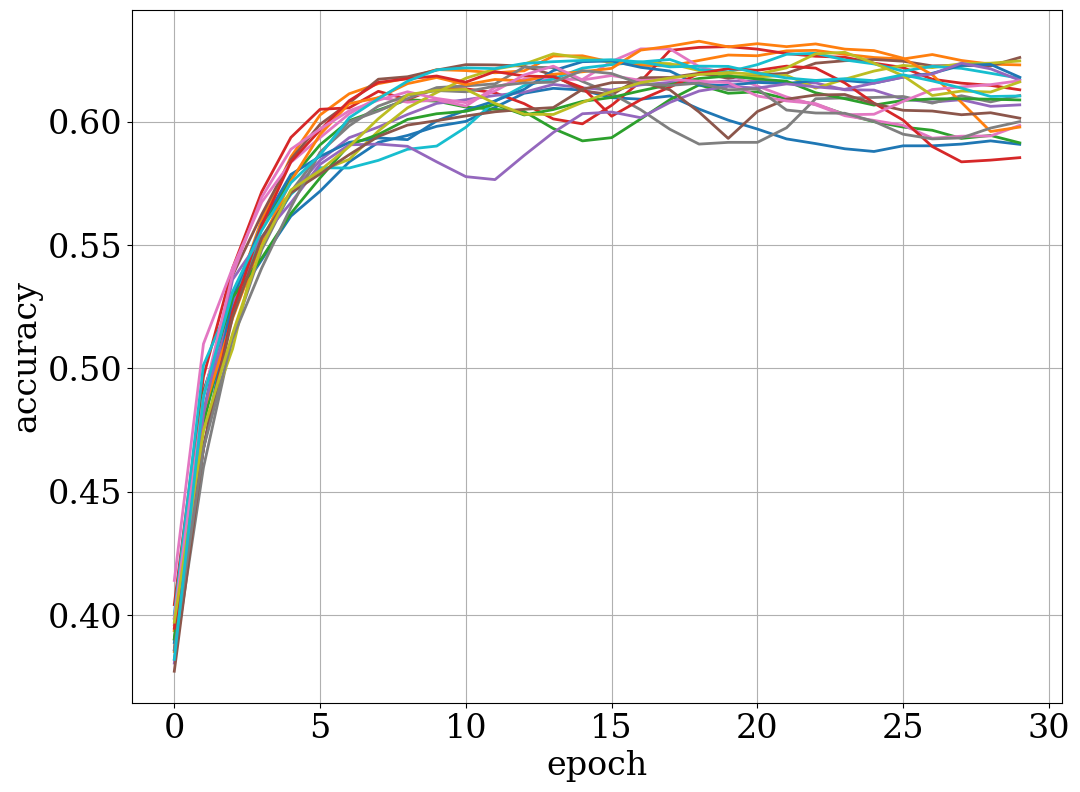

In [25]:
path = '../logs/acc_upd_mi_all_resnet_10_tiny.txt'

with open(path, "r") as read_file:
    data = [float(line.split()[1]) for line in read_file]
data = np.reshape(np.array(data), (-1, epoch_num))
accuracy_plot(data)

In [26]:
complete_trials = study.get_trials(deepcopy=False)
complete_trials.sort(key=lambda x: -x.values[0])

In [27]:
def build_distill_plot(trial):
    plt.rcParams["figure.figsize"] = (9, 6)
    plt.axis('off')
    beta = trial.params['beta']
    accuracy = trial.values[0]
    thickness = trial.user_attrs
    base_thicknes = 5
    teacher_points = [(1+i, 3) for i in range(9)]
    student_points = [(2*i + 2, 0) for i in range(4)]
    for point in teacher_points:
        plt.plot(*point, 'ro')
    for point in student_points:
        plt.plot(*point, 'go')
    
    for label, value in thickness.items():
        _, student_idx, teacher_idx = label.split('_')
        student_idx = int(student_idx)
        teacher_idx = int(teacher_idx)
        value = round(value, 3)
        x_values = [student_points[student_idx][0], teacher_points[teacher_idx][0]]
        y_values = [student_points[student_idx][1], teacher_points[teacher_idx][1]]
        plt.plot(x_values, y_values, 'b', linestyle="-", linewidth=base_thicknes*value)
    plt.title(f"Beta = {beta:0.3f}, accuracy = {accuracy:0.3f}")
    plt.show()

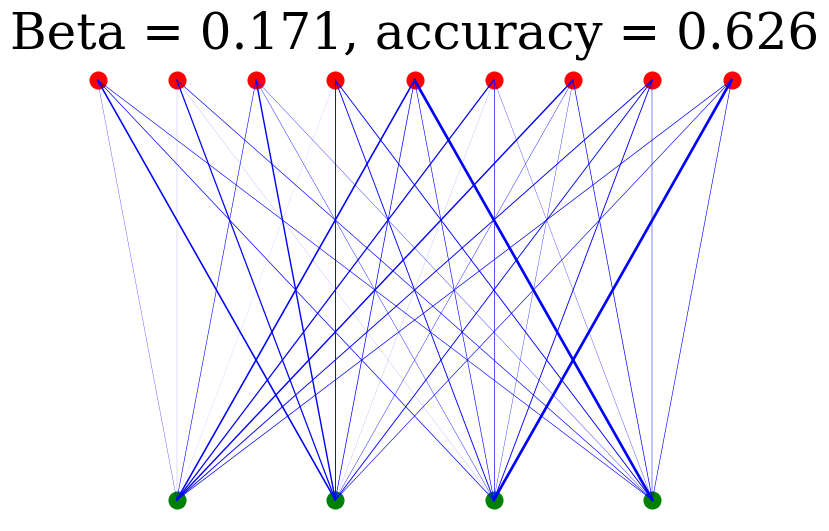

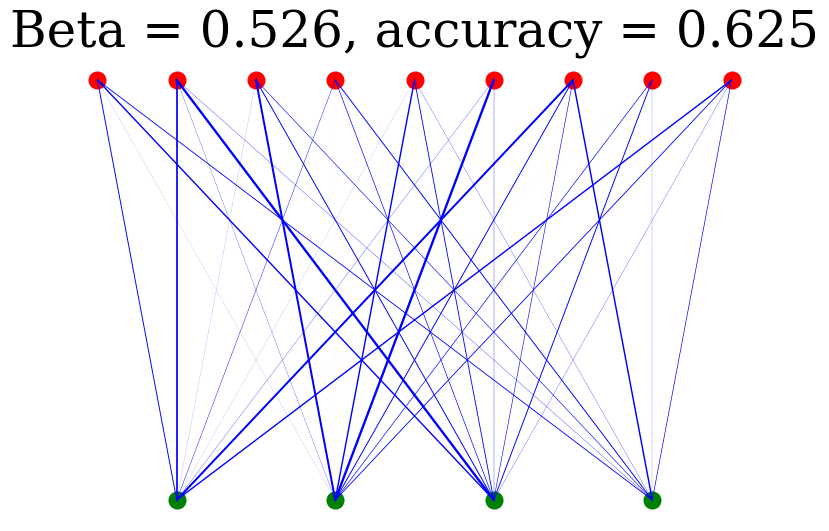

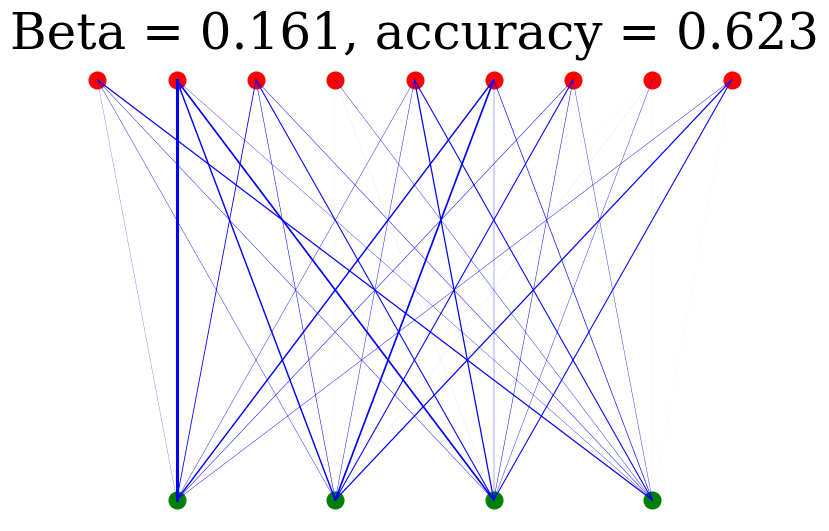

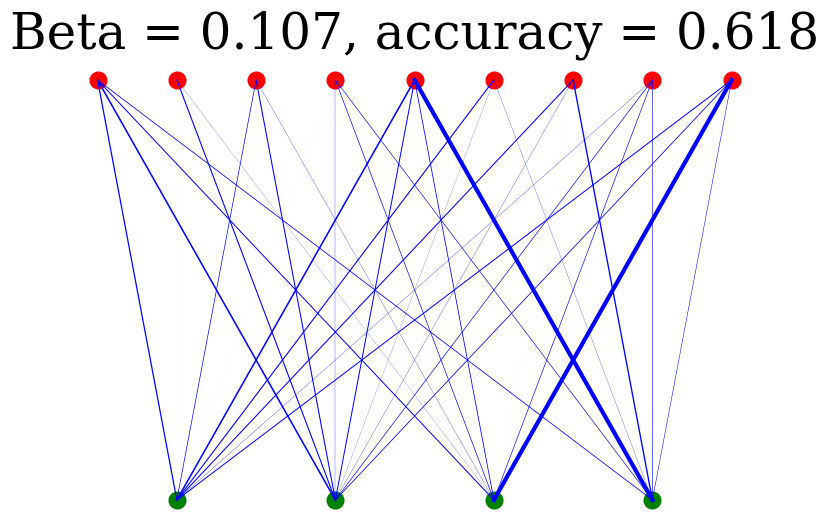

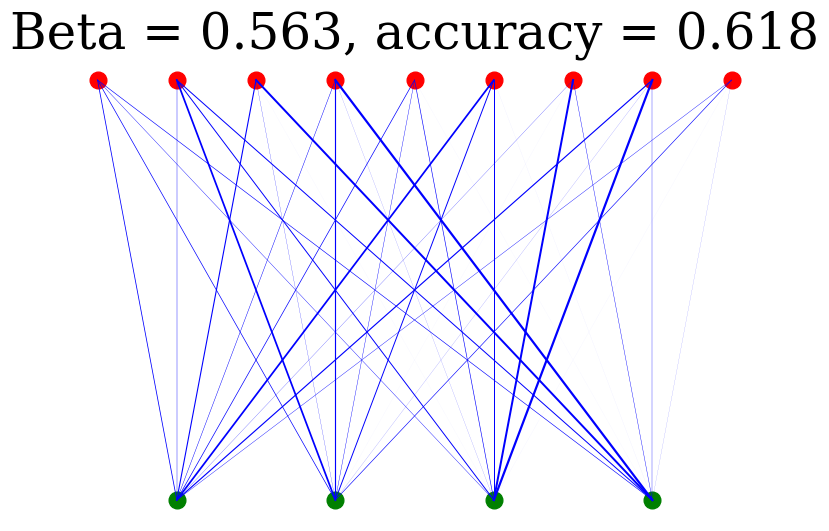

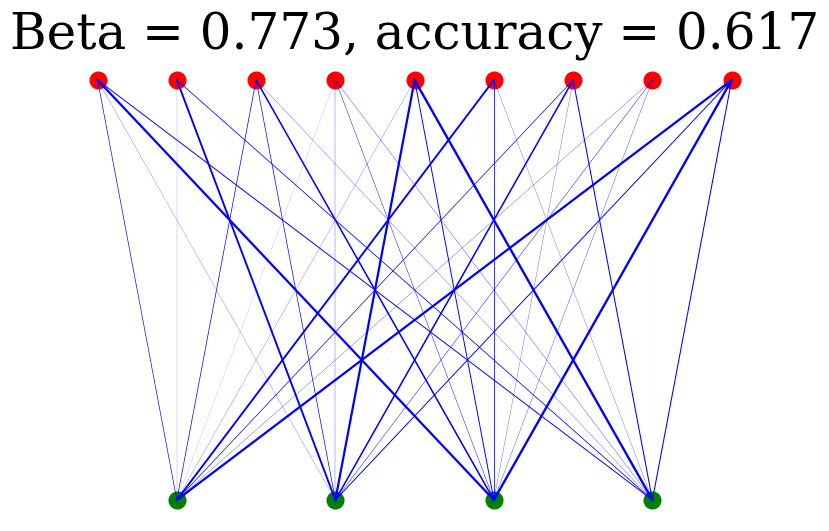

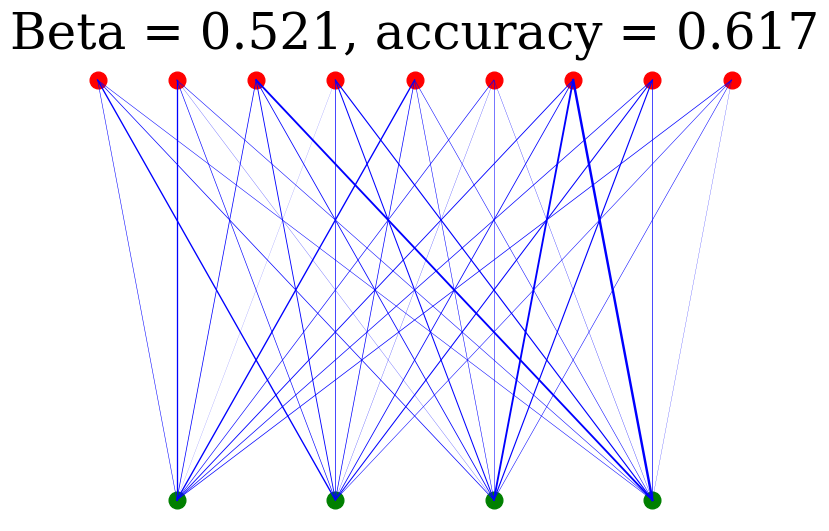

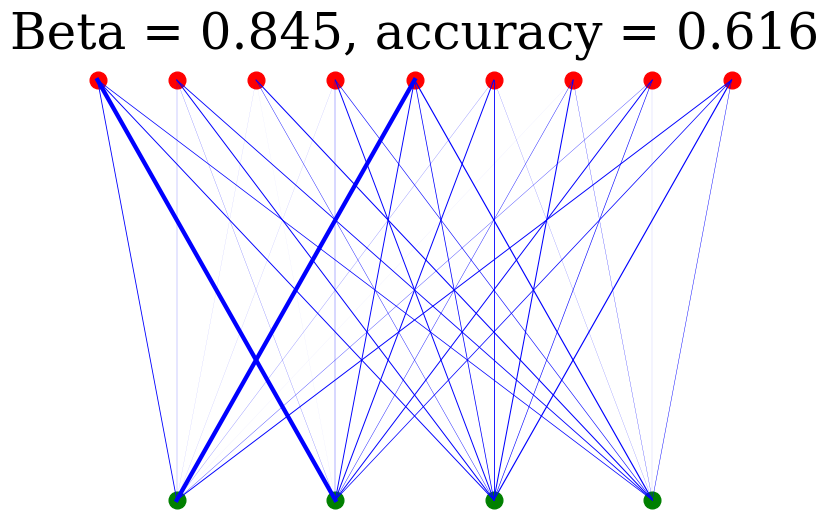

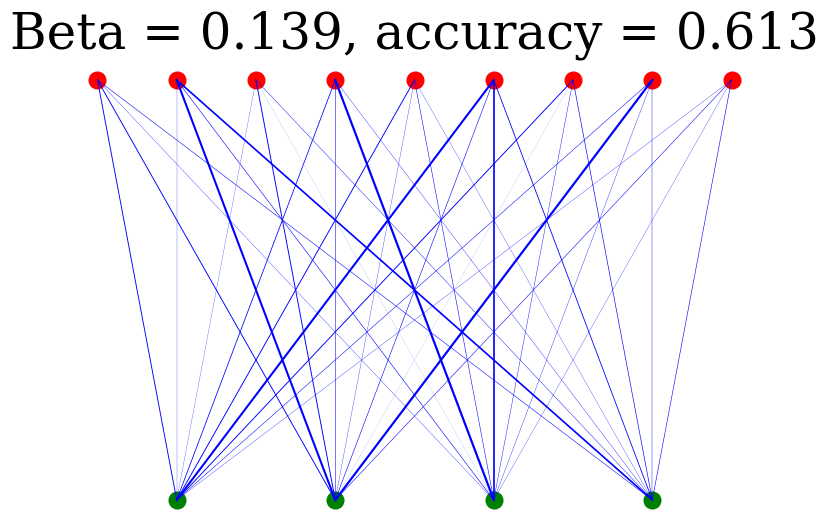

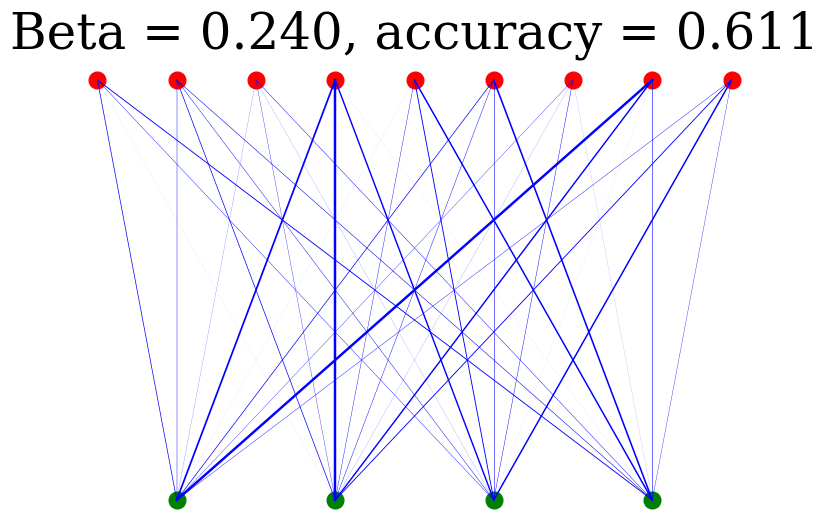

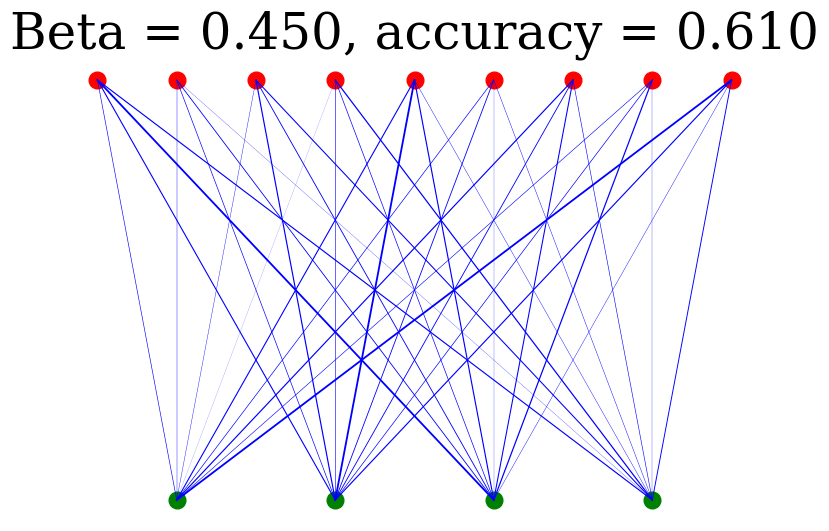

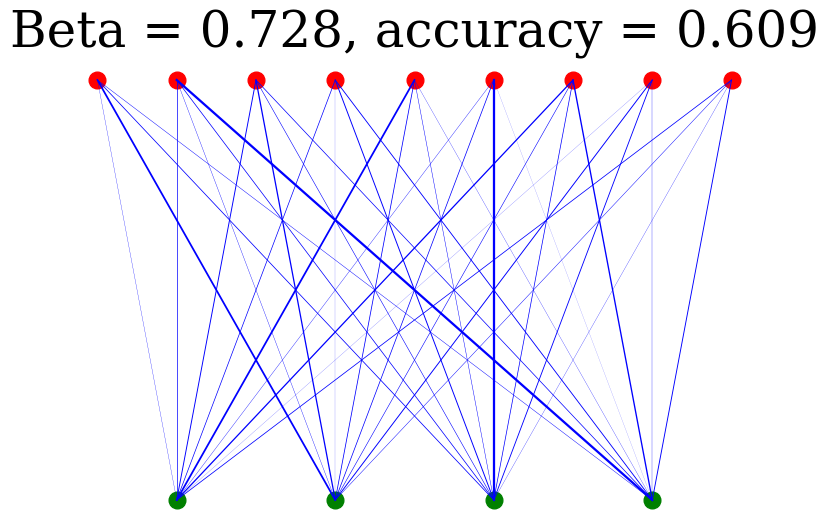

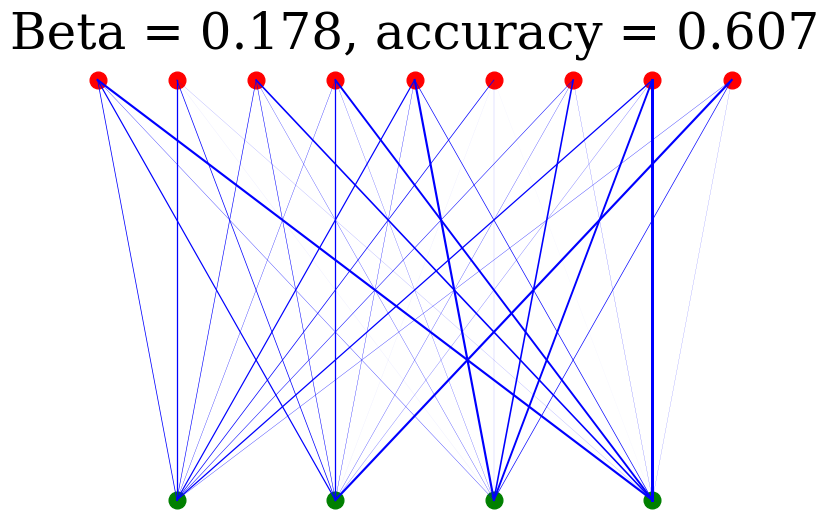

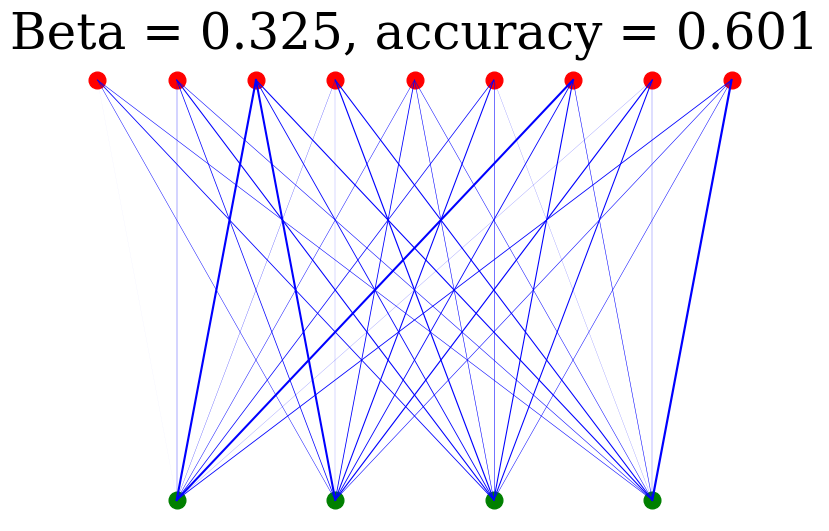

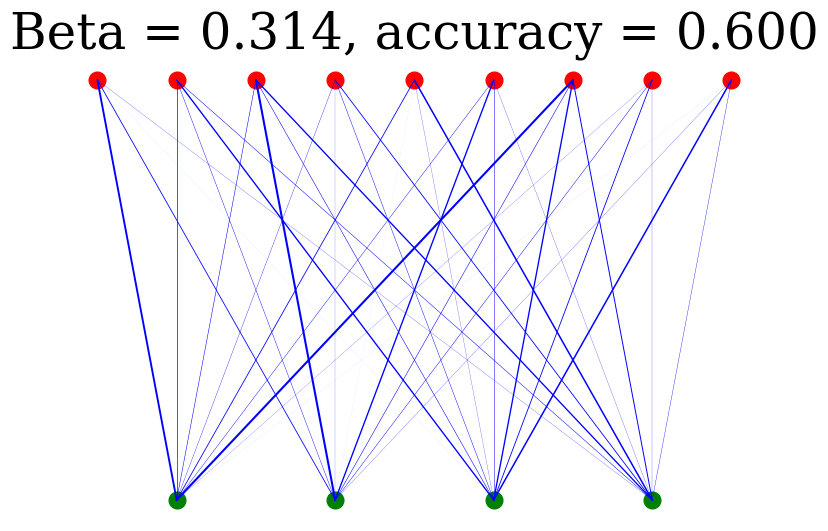

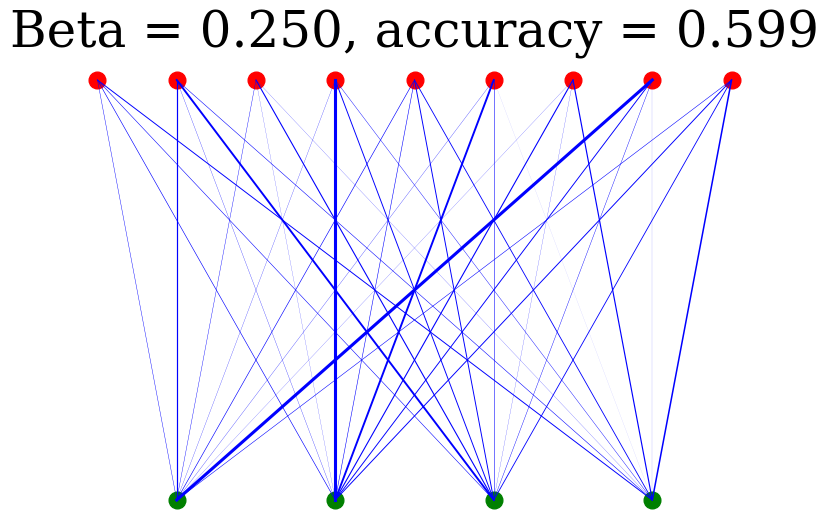

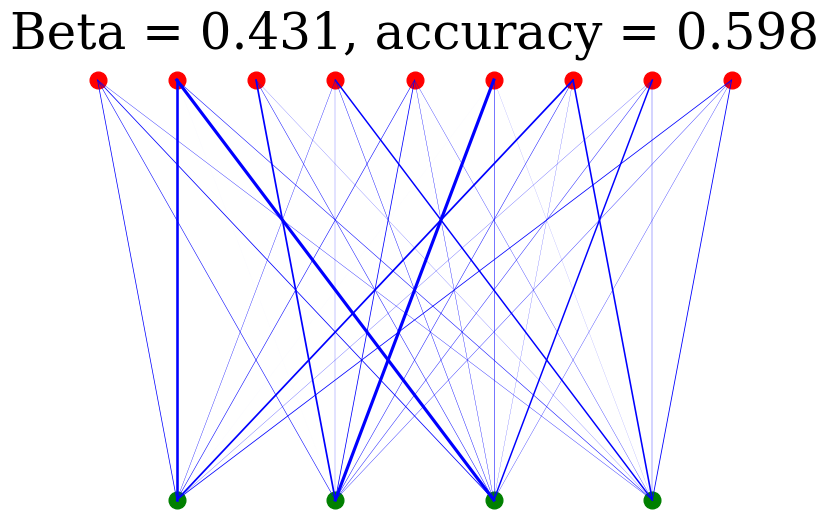

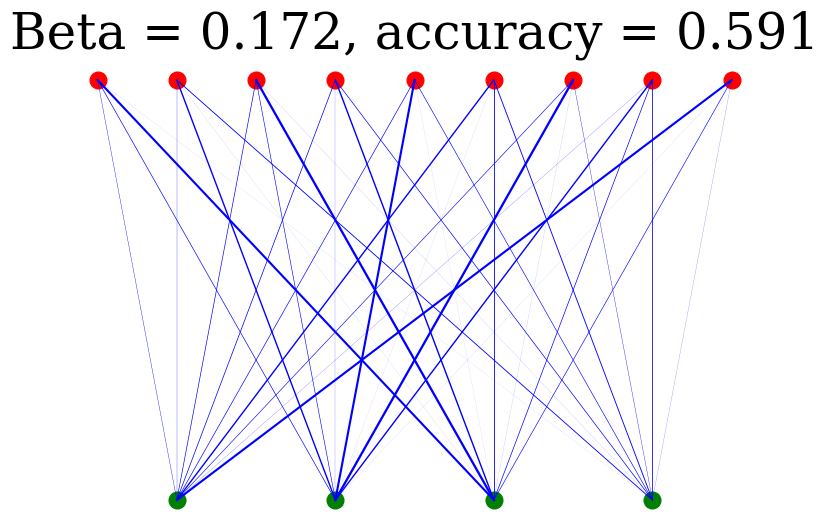

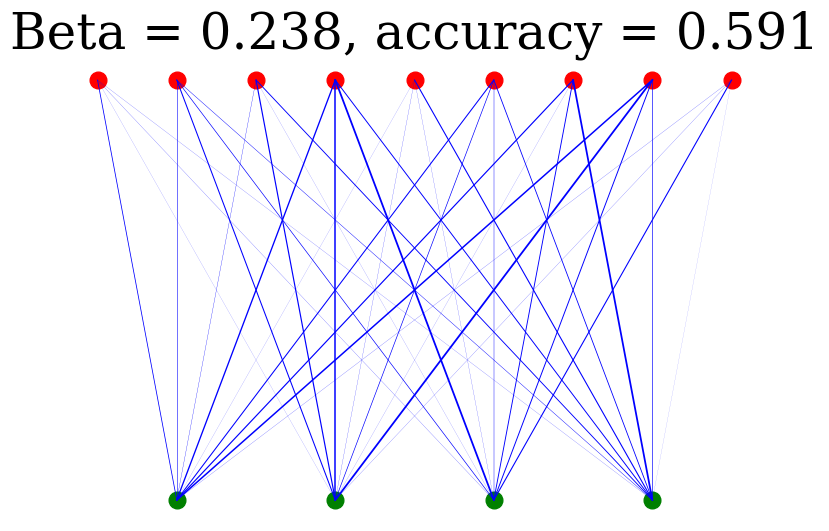

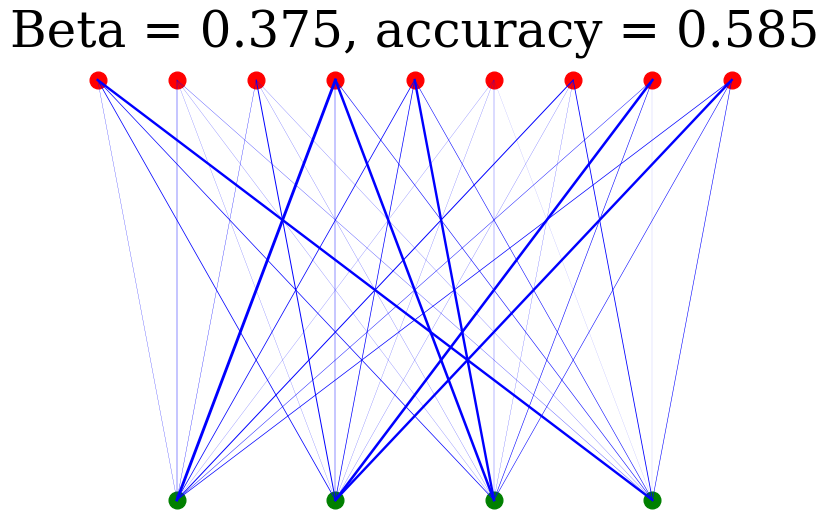

In [28]:
for trial in complete_trials:
    build_distill_plot(trial)